In [1]:
import os
import glob

import numpy as np
import xarray as xr

import csv
import pop_tools
import gsw

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmocean.cm as cmo
import cartopy
import matplotlib.ticker as ticker
from matplotlib import animation, gridspec
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import FuncFormatter

ccrs = cartopy.crs
cfeature = cartopy.feature

nature_coast = cartopy.feature.NaturalEarthFeature('physical', 'land', '50m',linewidth=0.5, edgecolor='black', facecolor='whitesmoke')

In [2]:
grid_name = 'POP_gx1v7'
region_defs = {
    'SubpolarAtlantic':[
        {'match': {'REGION_MASK': [6]}, 'bounds': {'TLAT': [10.0, 80.0], 'TLONG': [260.0, 360.0]}}   
    ],
    'NordicSea': [
        {'match': {'REGION_MASK': [9]}, 'bounds': {'TLAT': [10.0, 70.0], 'TLONG': [260.0, 360.0]}}
    ],
    'LabradorSea': [
        {'match': {'REGION_MASK': [8]}}]}
contour_mask = pop_tools.region_mask_3d(grid_name, region_defs=region_defs, mask_name='North Atlantic')
contour_mask = contour_mask.sum('region')  

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [3]:
grid_name = 'POP_gx1v7'
region_defs = {
        'subzero_Atlantic':[
            {'match': {'REGION_MASK': [6]}, 'bounds': {'TLAT': [10.0, 90.0], 'TLONG': [260.0, 360.0]}}
        ],
        'superzero_Atlantic':[
            {'match': {'REGION_MASK': [6]}, 'bounds': {'TLAT': [10.0, 90.0], 'TLONG': [0, 20.0]}}
        ],
        'Mediterranean': [
            {'match': {'REGION_MASK': [7]}}
        ],
        'LabradorSea': [
            {'match': {'REGION_MASK': [8]}, 'bounds': {'TLAT': [10.0, 70.0]}}
        ],
        'subzero_NordicSea': [
            {'match': {'REGION_MASK': [9]}, 'bounds': {'TLAT': [10.0, 90.0], 'TLONG': [260.0, 360.0]}}
        ],
        'superzero_NordicSea':[
            {'match': {'REGION_MASK': [9]}, 'bounds': {'TLAT': [10.0, 90.0], 'TLONG': [0, 20.0]}}
        ],
    }
mask = pop_tools.region_mask_3d(grid_name, region_defs=region_defs)
mask = mask.sum('region')

# Before 1980

In [9]:
ds_temp_aa = xr.open_dataset('/Data/skd/scratch/innag3580/comp/composites/Below_combined_TEMP_2.0_40_20_aa_hist.nc')
ds_salt_aa = xr.open_dataset('/Data/skd/scratch/innag3580/comp/composites/Below_combined_SALT_2.0_40_20_aa_hist.nc')
CT = gsw.conversions.CT_from_pt(ds_salt_aa['SALT'], ds_temp_aa['TEMP'])
sigma2 = gsw.density.sigma2(ds_salt_aa['SALT'], CT)
sigma2 = xr.DataArray(sigma2, name='DENS2', dims=ds_temp_aa['TEMP'].dims, coords=ds_temp_aa['TEMP'].coords)
ds_dens_aa = ds_temp_aa
ds_dens_aa = ds_dens_aa.drop_vars('TEMP')
ds_dens_aa['DENS2'] = sigma2

replacement_value = 0

In [10]:
grid_name = 'POP_gx1v7'
region_defs_lab = {'LabradorSea': [{'match': {'REGION_MASK': [8]}, 'bounds': {'TLAT': [45.0, 65.0]}}]} 
lab_mask3d = pop_tools.region_mask_3d(grid_name, region_defs=region_defs_lab, mask_name='lab')
lab_mask3d = lab_mask3d.sum('region') # apparently necessary even in this case

region_defs_irm = {'NorthAtlantic': [{'match': {'REGION_MASK': [6]}, 'bounds': {'TLAT': [60., 65.],'TLONG': [300., 340.]}}]}
irm_mask3d = pop_tools.region_mask_3d(grid_name, region_defs=region_defs_irm, mask_name='irm')
irm_mask3d = irm_mask3d.sum('region')

region_defs_esp = {'NorthAtlantic': [{'match': {'REGION_MASK': [6]}, 'bounds': {'TLAT': [50., 65.],'TLONG': [340., 355.]}}],}
esp_mask3d = pop_tools.region_mask_3d(grid_name, region_defs=region_defs_esp, mask_name='esp')
esp_mask3d = esp_mask3d.sum('region')

region_defs_csp = {'NorthAtlantic': [{'match': {'REGION_MASK': [6]}, 'bounds': {'TLAT': [50., 65.],'TLONG': [310., 340.]}}],}
csp_mask3d = pop_tools.region_mask_3d(grid_name, region_defs=region_defs_csp, mask_name='csp')
csp_mask3d = csp_mask3d.sum('region')

#region_defs_nac = {'NorthAtlantic': [{'match': {'REGION_MASK': [6]}, 'bounds': {'TLAT': [43., 50.],'TLONG': [305., 320.]}}],}
#nac_mask3d = pop_tools.region_mask_3d(grid_name, region_defs=region_defs_nac, mask_name='nac')
#nac_mask3d = nac_mask3d.sum('region')

lab_mask3d = lab_mask3d.roll(nlon=-100)
irm_mask3d = irm_mask3d.roll(nlon=-100)
esp_mask3d = esp_mask3d.roll(nlon=-100)
csp_mask3d = csp_mask3d.roll(nlon=-100)
#nac_mask3d = nac_mask3d.roll(nlon=-100)

In [11]:
lab_region_aa = ds_dens_aa.DENS2.where(lab_mask3d == 1).mean(dim=['nlat', 'nlon'])
irm_region_aa= ds_dens_aa.DENS2.where(irm_mask3d == 1).mean(dim=['nlat', 'nlon'])
esp_region_aa = ds_dens_aa.DENS2.where(esp_mask3d == 1).mean(dim=['nlat', 'nlon'])
csp_region_aa = ds_dens_aa.DENS2.where(csp_mask3d == 1).mean(dim=['nlat', 'nlon'])
#nac_region_aa = ds_dens_aa.DENS2.where(nac_mask3d == 1).mean(dim=['nlat', 'nlon'])

anom_lab_region_aa = lab_region_aa - lab_region_aa.isel(time=slice(0,40)).mean('time')
anom_irm_region_aa = irm_region_aa - irm_region_aa.isel(time=slice(0,40)).mean('time')
anom_esp_region_aa = esp_region_aa - esp_region_aa.isel(time=slice(0,40)).mean('time')
anom_csp_region_aa = csp_region_aa - csp_region_aa.isel(time=slice(0,40)).mean('time')
#anom_nac_region_aa = nac_region_aa - nac_region_aa.isel(time=slice(0,40)).mean('time')

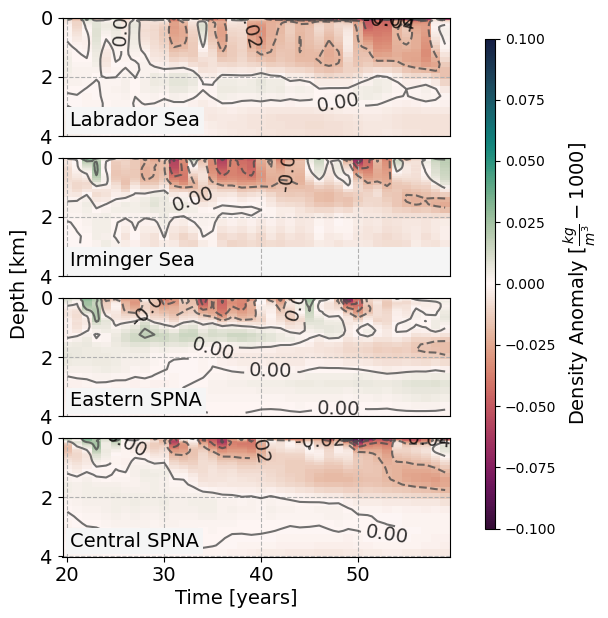

In [12]:
# Settings
vmin, vmax = -0.1, 0.1
fontsize = 14
num_subplots = 4

# Create a figure with 4 subplots of equal height
fig, axes = plt.subplots(num_subplots, 1, figsize=(5, 7))

# Define your data arrays and their corresponding titles
data_titles = [
    (anom_lab_region_aa, 'Labrador Sea'),
    (anom_irm_region_aa, 'Irminger Sea'),
    (anom_esp_region_aa, 'Eastern SPNA'),
    (anom_csp_region_aa, 'Central SPNA')
]

depth_range = (0, 400000)
start_time = 20  # Starting year

# Loop to create each subplot
for i, (data, title) in enumerate(data_titles):
    axes[i].set_facecolor('whitesmoke')

    pc = axes[i].pcolormesh(
        ds_dens_aa.time.sel(time=slice(start_time, None)), ds_dens_aa.z_t.sel(z_t=slice(*depth_range)),
        data.sel(time=slice(start_time, None), z_t=slice(*depth_range)).T, cmap=cmo.curl_r, vmin=vmin, vmax=vmax
    )
    contour = axes[i].contour(
        ds_dens_aa.time.sel(time=slice(start_time, None)), ds_dens_aa.z_t.sel(z_t=slice(*depth_range)),
        data.sel(time=slice(start_time, None), z_t=slice(*depth_range)).T, colors='#4d4d4d', alpha=0.8
    )
    axes[i].clabel(contour, inline=True, fontsize=fontsize, fmt='%1.2f', colors='black')
    axes[i].invert_yaxis()
    axes[i].tick_params(axis='both', which='major', labelsize=fontsize)
    axes[i].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x/100000)}'))
    axes[i].grid(True, linestyle='--')  # Add y grid lines

    # Hide x-ticks for all plots except the bottom plot
    if i != num_subplots - 1:
        axes[i].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    
    # Add title in a box with whitesmoke background and edged corners
    axes[i].text(0.02, 0.05, title, transform=axes[i].transAxes, fontsize=fontsize, 
                 verticalalignment='bottom', bbox={'boxstyle': 'square,pad=0.2', 'facecolor': 'whitesmoke', 'edgecolor': 'none'}, zorder=10)

fig.text(0.02, 0.5, 'Depth [km]', fontsize=fontsize, va='center', rotation='vertical')

fig.text(0.35, 0.05, 'Time [years]', fontsize=fontsize, va='center', rotation='horizontal')

plt.subplots_adjust(hspace=0.18)

# Add colorbar on the right and rotated by 90 degrees
cbar_ax = fig.add_axes([0.97, 0.15, 0.02, 0.7])  # Adjust position as necessary
cbar = fig.colorbar(pc, cax=cbar_ax, orientation='vertical')
cbar.set_label(r'Density Anomaly [$\frac{kg}{m^3} -1000$]', fontsize=fontsize)
cbar.ax.yaxis.set_label_position('right')
cbar.ax.yaxis.set_ticks_position('right')

#plt.tight_layout(pad=3.0)  # Adjust the padding
plt.show()
#plt.savefig('Figure_Density_Anomaly_2.png', bbox_inches='tight', dpi=300)

# After 1980

In [4]:
ds_temp_ghg = xr.open_dataset('/Data/skd/scratch/innag3580/comp/composites/Below_combined_TEMP_3.0_40_20.nc')
ds_salt_ghg = xr.open_dataset('/Data/skd/scratch/innag3580/comp/composites/Below_combined_SALT_3.0_40_20.nc')
CT = gsw.conversions.CT_from_pt(ds_salt_ghg['SALT'], ds_temp_ghg['TEMP'])
sigma2 = gsw.density.sigma2(ds_salt_ghg['SALT'], CT)
sigma2 = xr.DataArray(sigma2, name='DENS2', dims=ds_temp_ghg['TEMP'].dims, coords=ds_temp_ghg['TEMP'].coords)
ds_dens_ghg = ds_temp_ghg
ds_dens_ghg = ds_dens_ghg.drop_vars('TEMP')
ds_dens_ghg['DENS2'] = sigma2

replacement_value = 0

## Density depth propagation

In [5]:
grid_name = 'POP_gx1v7'
region_defs_lab = {'LabradorSea': [{'match': {'REGION_MASK': [8]}, 'bounds': {'TLAT': [45.0, 65.0]}}]} 
lab_mask3d = pop_tools.region_mask_3d(grid_name, region_defs=region_defs_lab, mask_name='lab')
lab_mask3d = lab_mask3d.sum('region') # apparently necessary even in this case

region_defs_irm = {'NorthAtlantic': [{'match': {'REGION_MASK': [6]}, 'bounds': {'TLAT': [60., 65.],'TLONG': [300., 340.]}}]}
irm_mask3d = pop_tools.region_mask_3d(grid_name, region_defs=region_defs_irm, mask_name='irm')
irm_mask3d = irm_mask3d.sum('region')

region_defs_esp = {'NorthAtlantic': [{'match': {'REGION_MASK': [6]}, 'bounds': {'TLAT': [50., 65.],'TLONG': [340., 355.]}}],}
esp_mask3d = pop_tools.region_mask_3d(grid_name, region_defs=region_defs_esp, mask_name='esp')
esp_mask3d = esp_mask3d.sum('region')

region_defs_csp = {'NorthAtlantic': [{'match': {'REGION_MASK': [6]}, 'bounds': {'TLAT': [50., 65.],'TLONG': [310., 340.]}}],}
csp_mask3d = pop_tools.region_mask_3d(grid_name, region_defs=region_defs_csp, mask_name='csp')
csp_mask3d = csp_mask3d.sum('region')

#region_defs_nac = {'NorthAtlantic': [{'match': {'REGION_MASK': [6]}, 'bounds': {'TLAT': [43., 50.],'TLONG': [305., 320.]}}],}
#nac_mask3d = pop_tools.region_mask_3d(grid_name, region_defs=region_defs_nac, mask_name='nac')
#nac_mask3d = nac_mask3d.sum('region')

lab_mask3d = lab_mask3d.roll(nlon=-100)
irm_mask3d = irm_mask3d.roll(nlon=-100)
esp_mask3d = esp_mask3d.roll(nlon=-100)
csp_mask3d = csp_mask3d.roll(nlon=-100)
#nac_mask3d = nac_mask3d.roll(nlon=-100)

In [6]:
lab_region_ghg = ds_dens_ghg.DENS2.where(lab_mask3d == 1).mean(dim=['nlat', 'nlon'])
irm_region_ghg = ds_dens_ghg.DENS2.where(irm_mask3d == 1).mean(dim=['nlat', 'nlon'])
esp_region_ghg = ds_dens_ghg.DENS2.where(esp_mask3d == 1).mean(dim=['nlat', 'nlon'])
csp_region_ghg = ds_dens_ghg.DENS2.where(csp_mask3d == 1).mean(dim=['nlat', 'nlon'])
#nac_region_ghg = ds_dens_ghg.DENS2.where(nac_mask3d == 1).mean(dim=['nlat', 'nlon'])

anom_lab_region_ghg = lab_region_ghg - lab_region_ghg.isel(time=slice(0,40)).mean('time')
anom_irm_region_ghg = irm_region_ghg - irm_region_ghg.isel(time=slice(0,40)).mean('time')
anom_esp_region_ghg = esp_region_ghg - esp_region_ghg.isel(time=slice(0,40)).mean('time')
anom_csp_region_ghg = csp_region_ghg - csp_region_ghg.isel(time=slice(0,40)).mean('time')
#anom_nac_region_ghg = nac_region_ghg - nac_region_ghg.isel(time=slice(0,40)).mean('time')

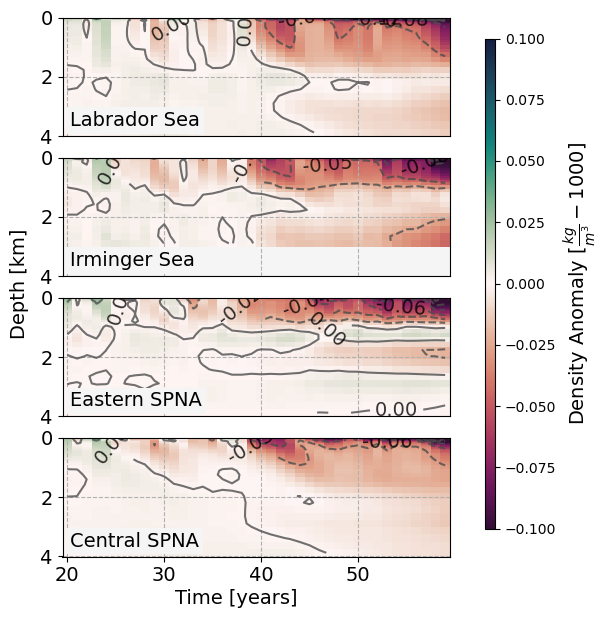

In [7]:
# Settings
vmin, vmax = -0.1, 0.1
fontsize = 14
num_subplots = 4

# Create a figure with 4 subplots of equal height
fig, axes = plt.subplots(num_subplots, 1, figsize=(5, 7))

# Define your data arrays and their corresponding titles
data_titles = [
    (anom_lab_region_ghg, 'Labrador Sea'),
    (anom_irm_region_ghg, 'Irminger Sea'),
    (anom_esp_region_ghg, 'Eastern SPNA'),
    (anom_csp_region_ghg, 'Central SPNA')
]

depth_range = (0, 400000)
start_time = 20  # Starting year

# Loop to create each subplot
for i, (data, title) in enumerate(data_titles):
    axes[i].set_facecolor('whitesmoke')

    pc = axes[i].pcolormesh(
        ds_dens_ghg.time.sel(time=slice(start_time, None)), ds_dens_ghg.z_t.sel(z_t=slice(*depth_range)),
        data.sel(time=slice(start_time, None), z_t=slice(*depth_range)).T, cmap=cmo.curl_r, vmin=vmin, vmax=vmax
    )
    contour = axes[i].contour(
        ds_dens_ghg.time.sel(time=slice(start_time, None)), ds_dens_ghg.z_t.sel(z_t=slice(*depth_range)),
        data.sel(time=slice(start_time, None), z_t=slice(*depth_range)).T, colors='#4d4d4d', alpha=0.8
    )
    axes[i].clabel(contour, inline=True, fontsize=fontsize, fmt='%1.2f', colors='black')
    axes[i].invert_yaxis()
    axes[i].tick_params(axis='both', which='major', labelsize=fontsize)
    axes[i].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{int(x/100000)}'))
    axes[i].grid(True, linestyle='--')  # Add y grid lines

    # Hide x-ticks for all plots except the bottom plot
    if i != num_subplots - 1:
        axes[i].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    
    # Add title in a box with whitesmoke background and edged corners
    axes[i].text(0.02, 0.05, title, transform=axes[i].transAxes, fontsize=fontsize, 
                 verticalalignment='bottom', bbox={'boxstyle': 'square,pad=0.2', 'facecolor': 'whitesmoke', 'edgecolor': 'none'}, zorder=10)

fig.text(0.02, 0.5, 'Depth [km]', fontsize=fontsize, va='center', rotation='vertical')

fig.text(0.35, 0.05, 'Time [years]', fontsize=fontsize, va='center', rotation='horizontal')

plt.subplots_adjust(hspace=0.18)

# Add colorbar on the right and rotated by 90 degrees
cbar_ax = fig.add_axes([0.97, 0.15, 0.02, 0.7])  # Adjust position as necessary
cbar = fig.colorbar(pc, cax=cbar_ax, orientation='vertical')
cbar.set_label(r'Density Anomaly [$\frac{kg}{m^3} -1000$]', fontsize=fontsize)
cbar.ax.yaxis.set_label_position('right')
cbar.ax.yaxis.set_ticks_position('right')

#plt.tight_layout(pad=3.0)  # Adjust the padding
plt.show()
#plt.savefig('Figure_Density_Anomaly_2.png', bbox_inches='tight', dpi=300)